In [49]:
# 
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gen import generate_data

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import grad

# Reproductibilité 
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device (GPU/CPU) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


 Using device: cpu


In [ ]:
# === Génération de données haute résolution (~10 000 points) ===
from datetime import datetime
def log(msg): print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

params = dict(
    tau=1e-11,           # s
    fluence=300.0,       # J/m^2
    wavelength=400e-9,   # m
    t_end=60e-12,        # durée totale simulée
    steps_per_tau=1600   # ⬅️ densité très élevée (~10k points)
)

log("Generating high-density data (~10k points)...")
time, Te, Tl, Tw, sigma_abs = generate_data(**params)

import pandas as pd, matplotlib.pyplot as plt, numpy as np
data = pd.DataFrame({"time_s": time, "T_e_K": Te, "T_l_K": Tl, "T_w_K": Tw})

# Infos pratiques
dt = float(time[1]-time[0]) if len(time) > 1 else float('nan')
log(f"points = {len(time):,} | dt = {dt:.3e} s | t_end = {params['t_end']:.3e} s")
log(f"sigma_abs = {sigma_abs:.3e} m^2")
display(data.head())

[14:27:07] Generating data targeting ~20,000 points ...
[14:27:07] Computed steps_per_tau = 3334 (ratio t_end/tau = 6.000)
[14:27:07] Actual points = 20,004 | dt = 2.999e-15 s | t_end = 6.000e-11 s | tau = 1.000e-11 s
[14:27:07] sigma_abs = 7.786e-18 m^2


,time_s,T_e_K,T_l_K,T_w_K
0,0.000000e+00,300.000000,300.000000,300.0
1,2.999400e-15,301.309467,300.000000,300.0
2,5.998800e-15,302.602377,300.000087,300.0
3,8.998200e-15,303.879113,300.000261,300.0
4,1.199760e-14,305.140042,300.000519,300.0


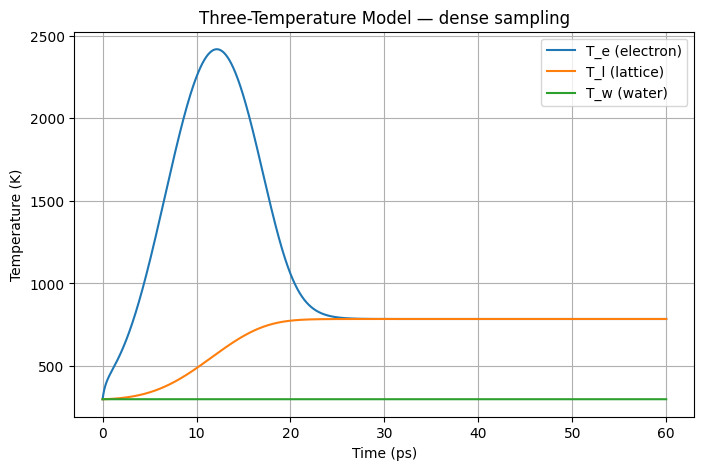

[14:27:07] Dense data plotted.


In [51]:
# Plot de contrôle
plt.figure(figsize=(8,5))
plt.plot(data["time_s"]/1e-12, data["T_e_K"], label="T_e (electron)")
plt.plot(data["time_s"]/1e-12, data["T_l_K"], label="T_l (lattice)")
plt.plot(data["time_s"]/1e-12, data["T_w_K"], label="T_w (water)")
plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Three-Temperature Model — dense sampling")
plt.grid(True); plt.legend(); plt.show()
log("Dense data plotted.")

# Tache 1 : Ajustement de courbes

Tâche 1 - Ajustement de courbes (modèle classique)

In [52]:
#Split chronologique (70/15/15)
def log(msg): 
    from datetime import datetime
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

X = data[["time_s"]].values.astype(np.float32)
y = data[["T_e_K", "T_l_K", "T_w_K"]].values.astype(np.float32)

N = len(X)
n_train = int(0.70 * N)
n_val   = int(0.15 * N)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

log(f"Split done → train:{len(X_train)} | val:{len(X_val)} | test:{len(X_test)} | total:{N}")


[14:27:07] Split done → train:14002 | val:3000 | test:3002 | total:20004


In [53]:
# === Normalisation des données ===
from sklearn.preprocessing import StandardScaler
import numpy as np

# normalise t ∈ [0,1] selon train
t_max = float(X_train.max())
X_train_s = X_train / t_max
X_val_s   = X_val   / t_max
X_test_s  = X_test  / t_max

# standardise les 3 sorties (fit sur train seulement)
y_scaler = StandardScaler().fit(y_train)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

log(f"t_max = {t_max:.3e} s")
log(f"y mean = {y_scaler.mean_}")
log(f"y scale = {y_scaler.scale_}")


[14:27:07] t_max = 4.199e-11 s
[14:27:07] y mean = [1174.67351907  654.69497826  300.        ]
[14:27:07] y scale = [591.12455586 179.35829824   1.        ]


In [54]:
# === Datasets et DataLoaders ===
class TimeTempDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = TimeTempDataset(X_train_s, y_train_s)
val_ds   = TimeTempDataset(X_val_s,   y_val_s)
test_ds  = TimeTempDataset(X_test_s,  y_test_s)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

log(f"DataLoaders ready → train:{len(train_loader)} batches | val:{len(val_loader)} | test:{len(test_loader)}")


[14:27:07] DataLoaders ready → train:219 batches | val:12 | test:12


In [55]:
# === Modèle MLP ===
class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden=(64,64), out_dim=3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = MLP().to(device)
params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
log(f"MLP initialisé → {params_count} paramètres entraînables sur {device}")


[14:27:07] MLP initialisé → 4483 paramètres entraînables sur cpu


In [56]:
# === Entraînement ===
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS, PATIENCE = 400, 30

best_val = np.inf
wait = 0
best_state = None
history = {"train": [], "val": []}

for epoch in range(1, EPOCHS + 1):
    # --- phase train ---
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)

    # --- phase val ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    improved = val_loss < best_val - 1e-8
    if improved:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1

    if epoch % 20 == 0 or epoch == 1 or improved:
        log(f"Epoch {epoch:03d} | Train={train_loss:.6f} | Val={val_loss:.6f} | Best={best_val:.6f} | Wait={wait}")
    if wait >= PATIENCE:
        log(f"Early stopping at epoch {epoch}")
        break

model.load_state_dict(best_state)
log("Best model restored.")


[14:27:07] Epoch 001 | Train=0.318021 | Val=0.089259 | Best=0.089259 | Wait=0
[14:27:08] Epoch 002 | Train=0.070507 | Val=0.008364 | Best=0.008364 | Wait=0
[14:27:08] Epoch 003 | Train=0.006164 | Val=0.001069 | Best=0.001069 | Wait=0
[14:27:11] Epoch 012 | Train=0.000122 | Val=0.000968 | Best=0.000968 | Wait=0
[14:27:12] Epoch 014 | Train=0.000077 | Val=0.000933 | Best=0.000933 | Wait=0
[14:27:13] Epoch 015 | Train=0.000065 | Val=0.000916 | Best=0.000916 | Wait=0
[14:27:13] Epoch 016 | Train=0.000050 | Val=0.000567 | Best=0.000567 | Wait=0
[14:27:13] Epoch 017 | Train=0.000041 | Val=0.000554 | Best=0.000554 | Wait=0
[14:27:14] Epoch 020 | Train=0.000039 | Val=0.000543 | Best=0.000543 | Wait=0
[14:27:15] Epoch 021 | Train=0.000023 | Val=0.000474 | Best=0.000474 | Wait=0
[14:27:16] Epoch 024 | Train=0.000025 | Val=0.000344 | Best=0.000344 | Wait=0
[14:27:22] Epoch 040 | Train=0.000020 | Val=0.000469 | Best=0.000344 | Wait=16
[14:27:27] Early stopping at epoch 54
[14:27:27] Best model res

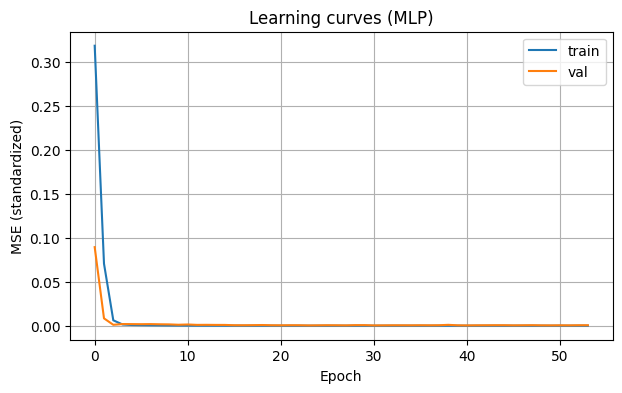

[14:27:27] Courbes d’apprentissage affichées.


In [57]:
plt.figure(figsize=(7,4))
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.xlabel("Epoch"); plt.ylabel("MSE (standardized)")
plt.title("Learning curves (MLP)")
plt.legend(); plt.grid(True)
plt.show()
log("Courbes d’apprentissage affichées.")


In [58]:
model.eval()
preds_s, trues_s = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds_s.append(model(xb).cpu().numpy())
        trues_s.append(yb.numpy())

preds_s = np.vstack(preds_s)
trues_s = np.vstack(trues_s)

# inverse scaling
preds = y_scaler.inverse_transform(preds_s)
trues = y_scaler.inverse_transform(trues_s)

def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))
for i, name in enumerate(["T_e_K","T_l_K","T_w_K"]):
    mae = mean_absolute_error(trues[:,i], preds[:,i])
    r   = rmse(trues[:,i], preds[:,i])
    log(f"{name:6s} | MAE={mae:.4f} K | RMSE={r:.4f} K")


[14:27:27] T_e_K  | MAE=84.5465 K | RMSE=87.8068 K
[14:27:27] T_l_K  | MAE=3.1419 K | RMSE=3.2787 K
[14:27:27] T_w_K  | MAE=0.0004 K | RMSE=0.0004 K


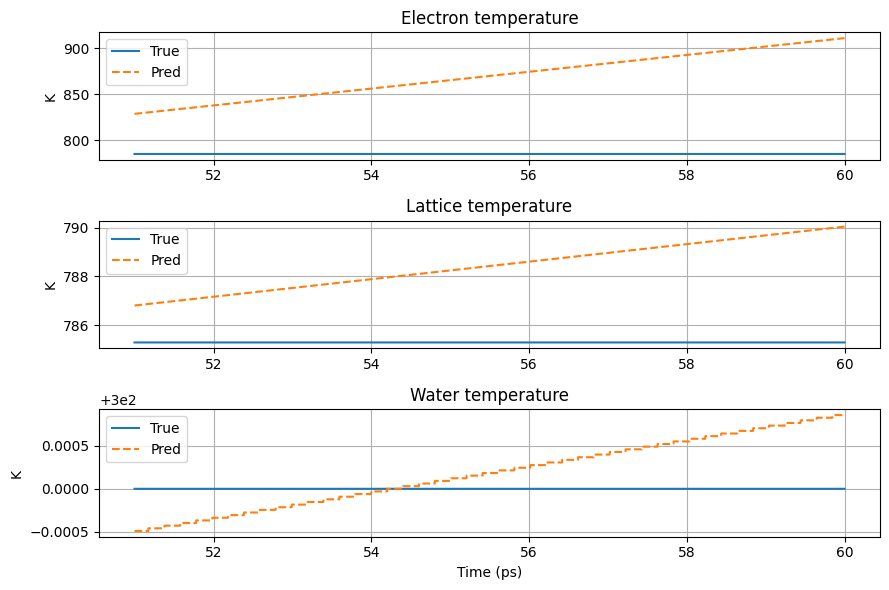

[14:27:29] Comparaison true/pred affichée.


In [59]:
test_plot = pd.DataFrame({
    "time_s": X_test.squeeze(),
    "T_e_true": trues[:,0], "T_l_true": trues[:,1], "T_w_true": trues[:,2],
    "T_e_pred": preds[:,0], "T_l_pred": preds[:,1], "T_w_pred": preds[:,2],
})

plt.figure(figsize=(9,6))
for i,(true_col,pred_col,title) in enumerate([
    ("T_e_true","T_e_pred","Electron temperature"),
    ("T_l_true","T_l_pred","Lattice temperature"),
    ("T_w_true","T_w_pred","Water temperature"),
]):
    plt.subplot(3,1,i+1)
    plt.plot(test_plot["time_s"]/1e-12, test_plot[true_col], label="True")
    plt.plot(test_plot["time_s"]/1e-12, test_plot[pred_col], "--", label="Pred")
    plt.ylabel("K"); plt.legend(); plt.grid(True); plt.title(title)
plt.xlabel("Time (ps)")
plt.tight_layout(); plt.show()
log("Comparaison true/pred affichée.")



# tache 2 : 

pour qui travaille dans la tache 2 , mettez ton travail en des cellules dans ce MarKdown pour eviter les conflits

# tache 3 :

meme chose pour la tache 3 